In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# set seaborn plot style
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=1.8)

# configure notebook plot size
plt.rcParams["figure.figsize"] = (14, 8)

warnings.filterwarnings('ignore')

# load dataframe generated by NBA_Data_FB_tipoff_Filter.py
# this particular dataset includes all games from 2015 through the 2021 season
first_basket_tipoff_df = pd.read_csv('first_baskets_tipoff.csv')

# load player info dataframe
Player_info_df = pd.read_csv('Player_info.csv', index_col=0)

In [2]:
first_basket_tipoff_df.head()

,URL,GameType,Location,Date,Time,WinningTeam,SecLeft,AwayTeam,AwayPlay_FirstBasket,AwayScore,...,JumpballTeamPoss(Home or Away),JumpballTeamPoss,FB_Team(Home or Away),FB_Team,FirstBasketTeamWonGame,FirstBasketTimeElapsed,TallerPlayerWonJump,HeavyOrLightWonJump,JumpPlayerGotFirstBasket,WinJump & FirstBasket
0,/boxscores/201510270ATL.html,regular,Philips Arena Atlanta Georgia,October 27 2015,8:00 PM,DET,681,DET,M. Morris makes 2-pt jump shot from 13 ft (ass...,2,...,Away,DET,Away,DET,True,39,Taller won,Heavier won,False,True
1,/boxscores/201510270CHI.html,regular,United Center Chicago Illinois,October 27 2015,8:00 PM,CHI,683,CLE,K. Love makes 2-pt dunk at rim (assist by L. J...,2,...,Home,CHI,Away,CLE,False,37,Shorter won,Lighter won,False,False
2,/boxscores/201510270GSW.html,regular,Oracle Arena Oakland California,October 27 2015,10:30 PM,GSW,695,NOP,NaN,0,...,Away,NOP,Home,GSW,True,25,Shorter won,Lighter won,False,False
3,/boxscores/201510280ORL.html,regular,Amway Center Orlando Florida,October 28 2015,7:00 PM,WAS,658,WAS,NaN,0,...,Away,WAS,Home,ORL,False,62,Taller won,Lighter won,False,False
4,/boxscores/201510280BOS.html,regular,TD Garden Boston Massachusetts,October 28 2015,7:30 PM,BOS,710,PHI,NaN,0,...,Home,BOS,Home,BOS,True,10,Taller won,Heavier won,False,True


In [3]:
# get fraction of time the team that won jump ball also got the first basket

first_basket_tipoff_df['WinJump & FirstBasket'].value_counts(normalize=True)

True     0.648422
False    0.351578
Name: WinJump & FirstBasket, dtype: float64

In [4]:
# get fraction of time the team home team got first basket

first_basket_tipoff_df['FB_Team(Home or Away)'].value_counts(normalize=True)

Home    0.511912
Away    0.488088
Name: FB_Team(Home or Away), dtype: float64

In [5]:
# get fraction of time a jump ball player got first basket

first_basket_tipoff_df['JumpPlayerGotFirstBasket'].value_counts(normalize=True)

False    0.732775
True     0.267225
Name: JumpPlayerGotFirstBasket, dtype: float64

In [6]:
# get fraction of time team gets first basket and wins the game

first_basket_tipoff_df['FirstBasketTeamWonGame'].value_counts(normalize=True)

True     0.537411
False    0.462589
Name: FirstBasketTeamWonGame, dtype: float64

In [7]:
def get_player_jump_win_loss_pct(player):
    '''
    get the jump ball win rate for a given NBA player

    Parameters
    ----------
    player : players name (string). Inlcude full player name

    '''
    # get the players link name used to locate player in the player_info_df
    link_name = Player_info_df.loc[Player_info_df['Name'] == player].index[0]
    
    # get a dataframe for which the player was involved in the jump ball
    player_df = first_basket_tipoff_df.loc[(first_basket_tipoff_df['JumpballAwayPlayer'].str.contains(link_name))
                                            | (first_basket_tipoff_df['JumpballHomePlayer'].str.contains(link_name))]
    
    # create a column to indicate whether play was home or away
    for index, row in player_df.iterrows():
        if link_name in row['JumpballHomePlayer']:
            player_df.at[index, 'PlayerIsHomeOrAway'] = 'Home'
        if link_name in row['JumpballAwayPlayer']:
            player_df.at[index, 'PlayerIsHomeOrAway'] = 'Away'
    
    # create a column to indicate whether or not the player won the jump ball
    player_df['JumpBallWon'] = player_df['PlayerIsHomeOrAway'] == player_df['JumpballTeamPoss(Home or Away)']
    
    # retrieve win rate and loss rate
    results = player_df['JumpBallWon'].value_counts(normalize=True)
    labels = results.index.to_list()
    percentages = results.to_list()
    
    if labels[0] == True:
        win_rate = percentages[0]
        loss_rate = percentages[1]
    else:
        win_rate = percentages[1]
        loss_rate = percentages[0]

    return win_rate, loss_rate

player = 'Giannis Antetokounmpo'
win_rate, loss_rate = get_player_jump_win_loss_pct(player)

print(f'{player} jump ball win rate: {win_rate*100}%, jump ball loss rate: {loss_rate*100}%')

Giannis Antetokounmpo jump ball win rate: 62.5%, jump ball loss rate: 37.5%


In [8]:
# first baskets for individual player

def get_first_baskets_made_by_player(player_name):
    '''
    returns the total number of first baskets made by player and 
    the type of baskets made

    Parameters
    ----------
    player_name : player_name : (str) players full name

    '''
    # get the players link name used to locate player in the player_info_df
    player_link_name = Player_info_df.loc[Player_info_df['Name'] == player_name].index[0]
    
    # get a dataframe for which player made the first basket of the game
    player_df = first_basket_tipoff_df.loc[(first_basket_tipoff_df['Shooter'].str.contains(player_link_name, na=False)) 
                                  | (first_basket_tipoff_df['FreeThrowShooter'].str.contains(player_link_name, na=False))]
    
    # get total number of first baskets made
    num_first_baskets = player_df['ShotType'].value_counts().sum()
    
    # get count of each type of basket made
    first_basket_counts = player_df['ShotType'].value_counts()
    
    return num_first_baskets, first_basket_counts

player = 'LeBron James'

num_first_baskets, first_basket_counts = get_first_baskets_made_by_player(player)
print(f'{player} total first baskets made: {num_first_baskets}')
print(f'{player} first baskets shot types:')
print(f'{first_basket_counts}')

LeBron James total first baskets made: 51
LeBron James first baskets shot types:
2-pt layup        23
2-pt jump shot    16
Foul shot          5
3-pt jump shot     4
2-pt dunk          3
Name: ShotType, dtype: int64


In [9]:
def get_top_first_baskets_all_players(n):
    '''
    Returns a dictionary containing the top n for number
    of first baskets made by a player
    
    Parameters
    ----------
    n : the number of top first basket players to return

    '''
    # get all the NBA players
    players = Player_info_df.index.values.tolist()
    
    # initiate a dictionary to store a players first basket count
    first_basket_count_dict = {}
    
    # for each player generate a dataframe and count the number of first baskets the player made
    for player in players:
        player_fb_df = first_basket_tipoff_df.loc[(first_basket_tipoff_df['Shooter'].str.contains(player, na=False))]
        # get full name of player
        player_name = Player_info_df.loc[player, 'Name']
        # if data frame is empty, player has never made a first basket
        if player_fb_df.empty:
            pass
        else:
            # else, add player to dictionary with their first basket count total
            first_basket_count_dict[player_name] = player_fb_df['ShotType'].value_counts().sum()
            
    # sort the dictionary and get the top n players
    first_basket_count_dict = dict(sorted(first_basket_count_dict.items(), key=lambda item: item[1], reverse=True)[:n])
    
    return first_basket_count_dict

get_top_first_baskets_all_players(15)

{'Karl-Anthony Towns': 89,
 'Steven Adams': 76,
 'Nikola Jokić': 74,
 'Anthony Davis': 69,
 'Brook Lopez': 68,
 'LaMarcus Aldridge': 67,
 'Jonas Valančiūnas': 66,
 'Nikola Vučević': 64,
 'Andre Drummond': 63,
 'Klay Thompson': 63,
 'Kyrie Irving': 62,
 'Giannis Antetokounmpo': 61,
 'Paul George': 59,
 'Clint Capela': 59,
 'Andrew Wiggins': 59}

# Plots

[Text(0.5, 0, 'Shot Type'),
 Text(0, 0.5, 'Percent'),
 Text(0.5, 1.0, 'Percent of first baskets made by shot type')]

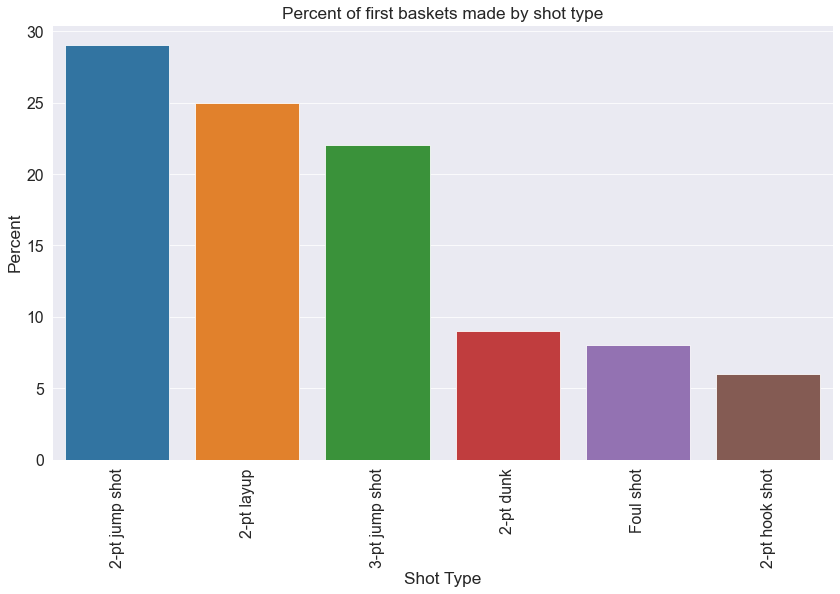

In [10]:
# plot first basket shot types

shot_types = first_basket_tipoff_df['ShotType'].value_counts().index.to_list()
shot_total = np.asarray(first_basket_tipoff_df['ShotType'].value_counts())
shot_total_percent = np.around((shot_total / np.sum(shot_total)) * 100, 0)
g = sns.barplot(x=shot_types, y=shot_total_percent)
g.set_xticklabels(g.get_xticklabels(), rotation=90) 
g.set(xlabel ="Shot Type", ylabel = "Percent", title ='Percent of first baskets made by shot type')

[Text(0.5, 1.0, 'Shot Distance Distribution')]

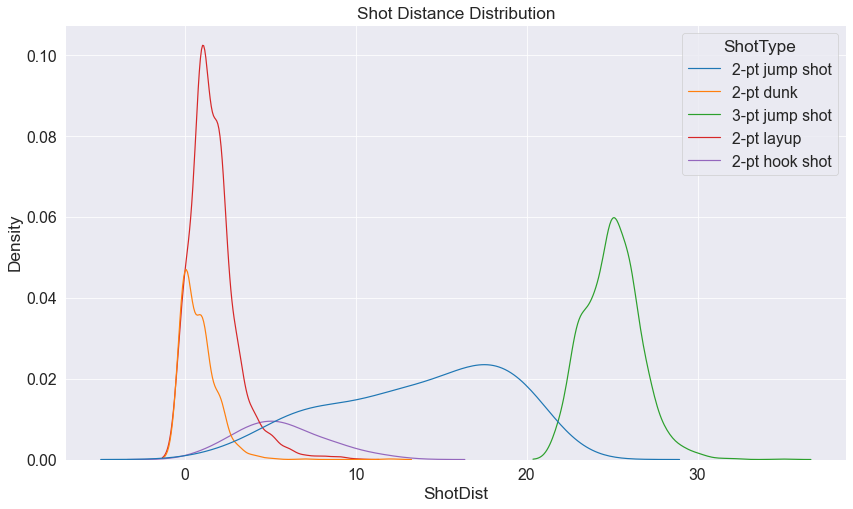

In [11]:
# plot shot distance distribution for first baskets that are not foul shots

df_no_foul_shots = first_basket_tipoff_df.loc[first_basket_tipoff_df['ShotType'] != 'Foul shot']

sns.kdeplot(data=df_no_foul_shots, x='ShotDist', hue='ShotType', palette='tab10', bw_adjust=1.5).set(title='Shot Distance Distribution')

[Text(0.5, 1.0, 'First Basket Jump Shot Distance')]

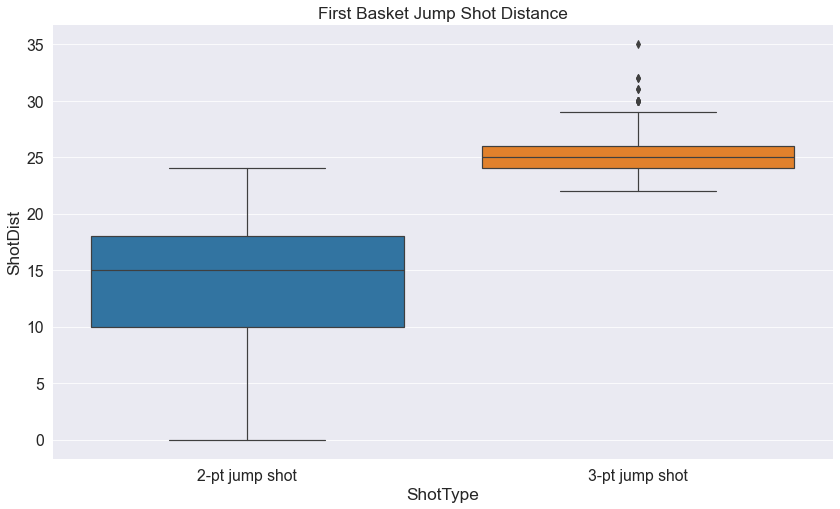

In [12]:
# plot shot distance box plot for 2 & 3 point jump shots

df_jump_shots = first_basket_tipoff_df.loc[first_basket_tipoff_df['ShotType'].isin(['2-pt jump shot', '3-pt jump shot'])]
sns.boxplot(y='ShotDist', x='ShotType', data=df_jump_shots).set(title='First Basket Jump Shot Distance')

[Text(0.5, 1.0, 'First Basket Time Distribution')]

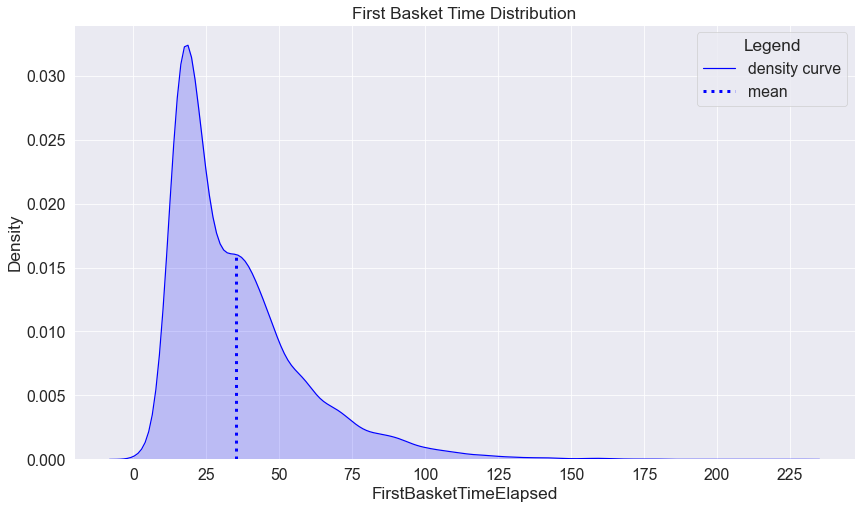

In [13]:
# plot distribution of time elapsed until the first basket is made

# get average time before first basket is made
mean = first_basket_tipoff_df['FirstBasketTimeElapsed'].mean()

g = sns.kdeplot(data=first_basket_tipoff_df, x='FirstBasketTimeElapsed', color='blue', shade=False)
# get denisty curve
kdeline = g.lines[0]
# get x,y values from curve
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
# interpolate height of curve at mean
height = np.interp(mean, xs, ys)
# add vertical mean line
g.vlines(mean, 0, height, color='blue', linewidth=3, ls=':')
# fill area of density curve
g.fill_between(xs, 0, ys, facecolor='blue', alpha=0.2)
# add legend
g.legend(title='Legend', loc='upper right', labels=['density curve', 'mean'])
# customize x tick marks
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
g.set(title='First Basket Time Distribution')

[Text(0.5, 1.0, 'First Basket Time Per Shot Type')]

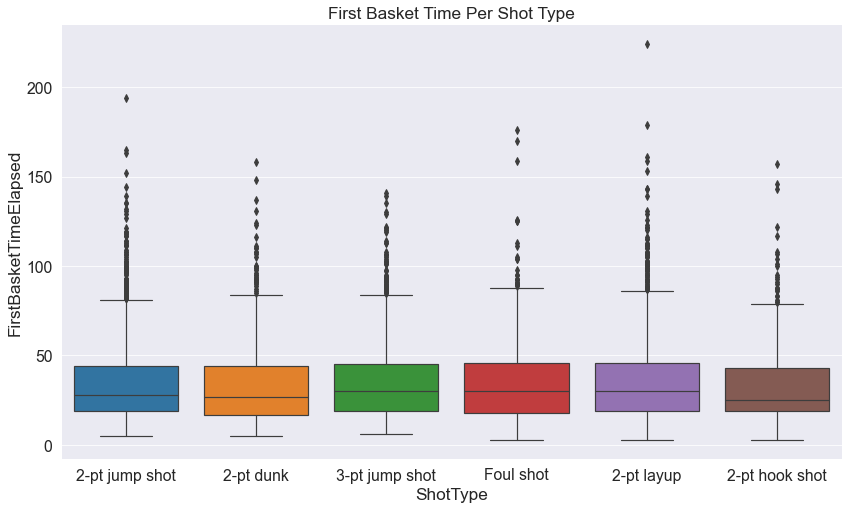

In [14]:
# show box plot for first basket times by shot type

f = sns.boxplot(data=first_basket_tipoff_df, x='ShotType', y='FirstBasketTimeElapsed')
f.set(title='First Basket Time Per Shot Type')